In [1]:
import pyspark as spark
import datetime, time
import pandas as pd
import networkx as nx
from functools import reduce
from pyspark.sql import Window
from pyspark.sql.types import (StructField, StringType,FloatType, 
                               DoubleType, IntegerType, StructType,
                              DateType)
from pyspark.sql import functions as F
from pyspark.sql import DataFrame as spDataFrame


from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (Binarizer, OneHotEncoder, StringIndexer, HashingTF, 
                                Tokenizer, StandardScaler, VectorAssembler,
                               OneHotEncoder, StringIndexer, VectorIndexer)
from pyspark.ml.classification import LogisticRegression, LinearSVC, LinearSVCModel
from pyspark.ml.evaluation import HasFeaturesCol
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
import matplotlib.pyplot as plt
#from tokenizer import Tokenizer

In [2]:
def unionAll(*dfs):
    return reduce(spDataFrame.unionAll, dfs)

This is to setup the sparksession. If additional resources need to be allocated it is done with this command

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName('Capstone Analysis') \
        .config("spark.driver.memory", "45g") \
        .config("spark.driver.cores", "10") \
        .config("spark.dirver.maxResultSize", "8g") \
        .config("spark.executor.memory", "6g") \
        .config("spark.files.maxPartitionBytes", "536870912") \
        .getOrCreate()

In [4]:
spark.sparkContext.uiWebUrl

'http://genuse50.engr.smu.edu:4041'

## Import DATA

In [6]:
proc_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('proc_name',StringType(),True),
                   StructField('strt',StringType())]
proc_final_struc = StructType(fields = proc_data_schema)
proc = spark.read.csv('../Dataset/proc.txt',schema=proc_final_struc)

auth_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_user@domain',StringType(),True),
                   StructField('dest_user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True),
                   StructField('auth_type',StringType(),True),
                   StructField('logon_type',StringType(),True),
                   StructField('auth_orient',StringType(),True),
                   StructField('success',StringType(),True)]
auth_final_struc = StructType(fields = auth_data_schema)
auth = spark.read.csv('../Dataset/auth.txt',schema=auth_final_struc )

flows_data_schema = [StructField('time',IntegerType(),False),
                   StructField('dur',IntegerType(),False),
                   StructField('src_comp',StringType(),False),
                   StructField('src_port',StringType(),False),
                   StructField('dest_comp',StringType(),False),
                   StructField('dest_port',StringType(),False),
                   StructField('protocol',StringType(),False),
                   StructField('pkt_cnt',IntegerType(),False),
                   StructField('byte_cnt',IntegerType(),False)]
flows_final_struc = StructType(fields = flows_data_schema)
flows = spark.read.csv('../Dataset/flows.txt',schema=flows_final_struc )

dns_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('cmp_resolved',StringType(),True)]
dns_final_struc = StructType(fields = dns_data_schema)
dns = spark.read.csv('../Dataset/dns.txt',schema=dns_final_struc)

redteam_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True)]
redteam_final_struc = StructType(fields = redteam_data_schema)
redteam = spark.read.csv('../Dataset/redteam.txt',schema=redteam_final_struc)

In [11]:
dns.show(n=5,truncate=True)

+----+--------+------------+
|time|src_comp|cmp_resolved|
+----+--------+------------+
|   2|   C4653|       C5030|
|   2|   C5782|      C16712|
|   6|   C1191|        C419|
|  15|   C3380|      C22841|
|  18|   C2436|       C5030|
+----+--------+------------+
only showing top 5 rows



In [14]:
dns_group_count = dns.groupby(dns.src_comp, dns.cmp_resolved).count()

In [15]:
dns_group_count.show()

+--------+------------+-----+
|src_comp|cmp_resolved|count|
+--------+------------+-----+
|   C6037|        C586|  102|
|   C6367|        C706|  414|
|   C9219|        C586|  104|
|  C10331|        C625|   27|
|   C5794|        C528|  111|
|  C13303|        C625|   33|
|   C2668|       C1707| 1420|
|  C13669|        C529|   44|
|   C1183|       C5030|  710|
|  C14280|       C1685|  951|
|  C14439|       C1065|   48|
|   C7221|       C1707|  902|
|  C12019|        C231|   24|
|   C7654|        C706|  194|
|  C14917|        C467|   54|
|  C25133|       C2109|    9|
|  C15207|       C1707|  325|
|  C17837|       C1707|   85|
|   C6621|       C1685|   93|
|   C6747|        C743|   32|
+--------+------------+-----+
only showing top 20 rows



This code is supposed to map the DNS connections into a network map

In [16]:
dns_graph = dns_group_count.toPandas()

In [110]:
redteam.show()

+------+-----------+--------+---------+
|  time|user@domain|src_comp|dest_comp|
+------+-----------+--------+---------+
|150885|  U620@DOM1|  C17693|    C1003|
|151036|  U748@DOM1|  C17693|     C305|
|151648|  U748@DOM1|  C17693|     C728|
|151993| U6115@DOM1|  C17693|    C1173|
|153792|  U636@DOM1|  C17693|     C294|
|155219|  U748@DOM1|  C17693|    C5693|
|155399|  U748@DOM1|  C17693|     C152|
|155460|  U748@DOM1|  C17693|    C2341|
|155591|  U748@DOM1|  C17693|     C332|
|156658|  U748@DOM1|  C17693|    C4280|
|210086|  U748@DOM1|  C18025|    C1493|
|210294|  U748@DOM1|  C18025|    C1493|
|210312|  U748@DOM1|  C18025|    C1493|
|218418|  U748@DOM1|  C17693|     C504|
|227052|  U748@DOM1|  C17693|     C148|
|227408|  U748@DOM1|  C17693|     C148|
|227520|  U748@DOM1|  C17693|     C148|
|227780|  U748@DOM1|  C17693|     C148|
|228024|  U748@DOM1|  C17693|     C148|
|228150|  U748@DOM1|  C17693|     C148|
+------+-----------+--------+---------+
only showing top 20 rows



In [112]:
redteam_group_count = redteam.groupby(redteam.src_comp, redteam.dest_comp).count()
redteam_graph = redteam_group_count.toPandas()


In [120]:
redteam_src = redteam_graph.src_comp
redteam_dest = redteam_graph.dest_comp
redteam_makeup = {}
for row in redteam_src:
    if row in redteam_dest:
        redteam_makeup[row]='purple'
    else:
        redteam_makeup[row]='red'
for row in (set(redteam_dest)-set(redteam_src)):
    redteam_makeup[row]='green'
    

In [108]:
A = nx.from_pandas_edgelist(auth_graph, 'src_comp','dest_comp','count')

In [124]:
dns_graph.shape

(425025, 3)

In [96]:
new_dns_graph = dns_graph.sample(2500)
new_dns_graph = dns_graph.copy()
G = nx.from_pandas_edgelist(new_dns_graph, 'src_comp','cmp_resolved','count')

/usr/local/es7/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


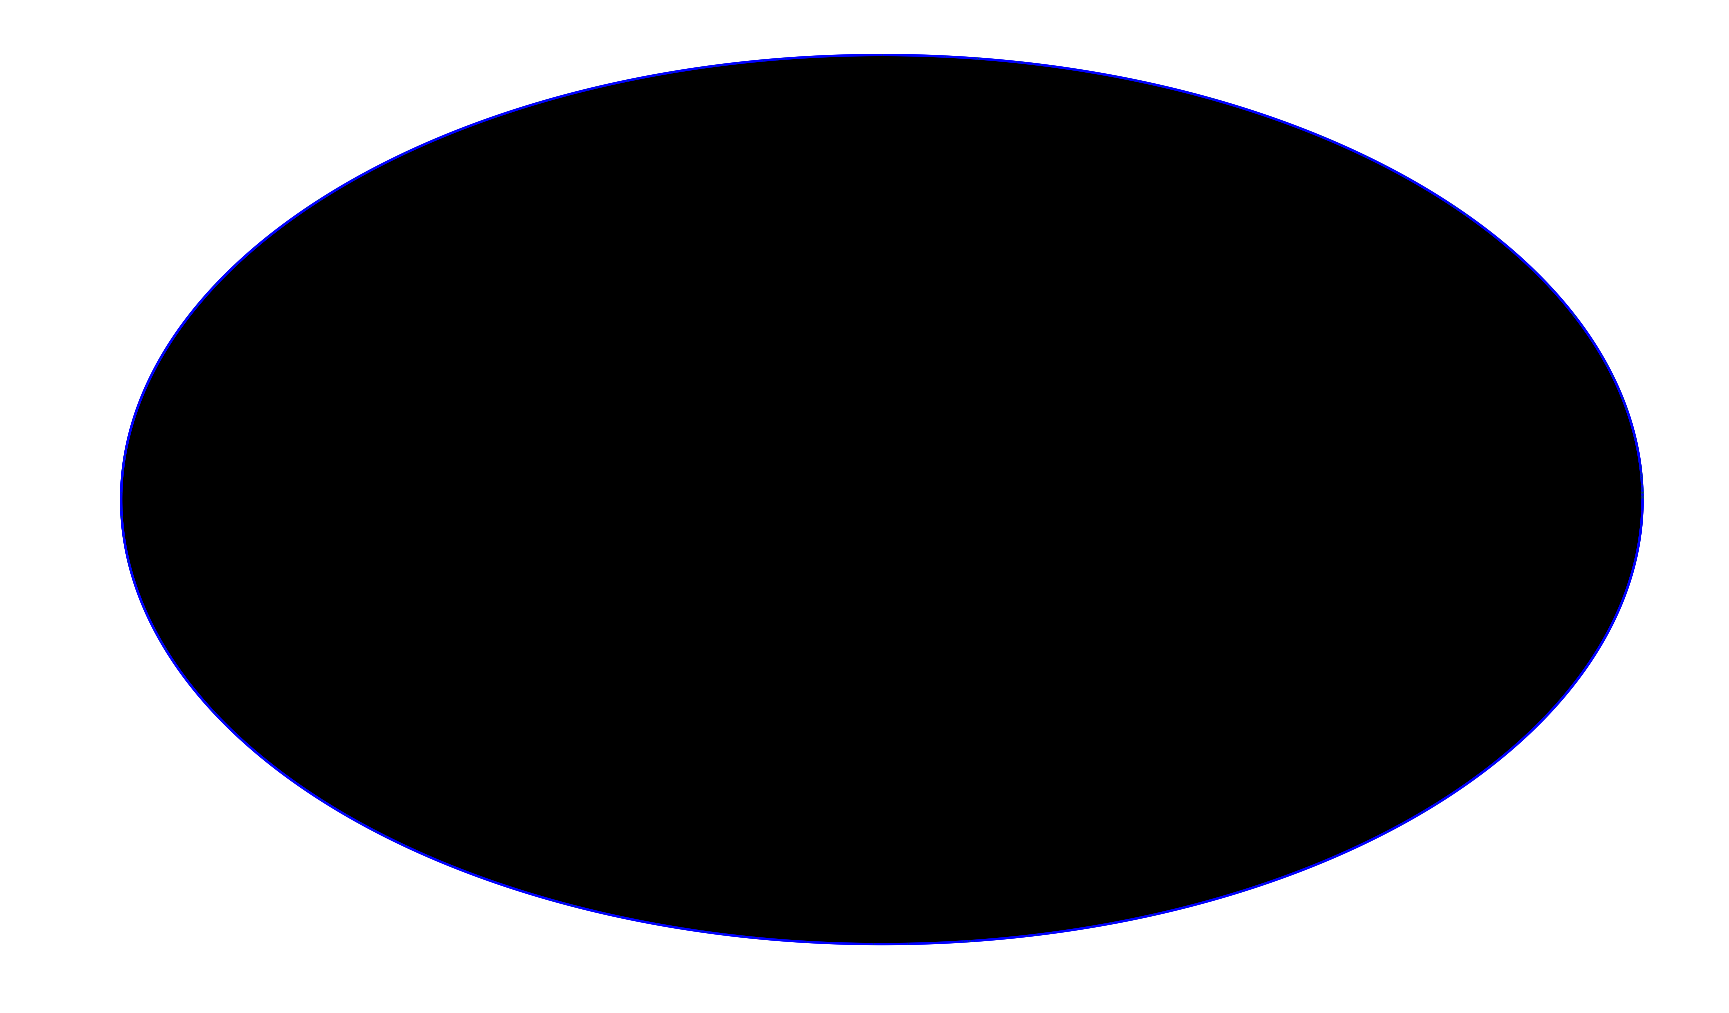

In [129]:
new_dns_graph = dns_graph.sample(25000)
new_dns_graph = dns_graph.copy()
G = nx.from_pandas_edgelist(new_dns_graph, 'src_comp','cmp_resolved','count')
for component in list(nx.connected_components(G)):
    if len(component)<25:
        for node in component:
            G.remove_node(node)


fig, ax = plt.subplots(figsize=(30,18))

color_map = []
size_map = []
for node in G:
    if node in redteam_makeup.keys():
        color_map.append(redteam_makeup[node])
        size_map = [100]
    else:
        color_map.append('blue')
        size_map = [1]
        


options = {
    'node_color': color_map,
    'node_size': size_map,
    'line_color': 'grey',
    'linewidths': 1,
    'width': .1,
    'with_labels':False,
    'arrows':True
}
# plt.colorbar(pc)

nx.draw_circular(G,**options)


fig.show()

In [28]:
from operator import itemgetter
node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
hub_ego = nx.ego_graph(G, largest_hub)
# Draw graph
pos = nx.spring_layout(hub_ego)


## Transform Data

This will be where we split all user@domain columns into user and domain columns

In [11]:
proc_split = F.split(proc['user@domain'],'@')
proc = proc.withColumn('src_user',proc_split.getItem(0))
proc = proc.withColumn('src_dmn',proc_split.getItem(1))
proc = proc.drop('user@domain')

proc = proc.withColumn('type',F.lit('Process'))

In [12]:
auth_src_split = F.split(auth['src_user@domain'],'@')
auth = auth.withColumn('src_user',auth_src_split.getItem(0))
auth = auth.withColumn('src_dmn',auth_src_split.getItem(1))

auth_dest_split = F.split(auth['dest_user@domain'],'@')
auth = auth.withColumn('dest_user',auth_dest_split.getItem(0))
auth = auth.withColumn('dest_dmn',auth_dest_split.getItem(1))

auth = auth.drop('src_user@domain','dest_user@domain')

auth = auth.withColumn('type',F.lit('Auth'))

In [13]:
redteam_split = F.split(redteam['user@domain'],'@')
redteam = redteam.withColumn('src_user',redteam_split.getItem(0))
redteam = redteam.withColumn('src_dmn',redteam_split.getItem(1))

redteam = redteam.drop('user@domain')

redteam = redteam.withColumn('type',F.lit('RedTeam'))

In [14]:

flows = flows.withColumn('avg_pkt_size', (flows['byte_cnt']/flows['pkt_cnt']).cast(DoubleType()))
flows = flows.na.drop(how='all')

flows = flows.withColumn('type',F.lit('DataFlow'))

# Test/Train split

In [15]:
split_days = 3
split_range = split_days * 3600 * 24

In [16]:
#Split data into train/test segments. This will be done on the first number of days

redteam = redteam.filter(redteam.time <= split_range)

dns = dns.filter(dns.time <= split_range)

proc = proc.filter(proc.time <= split_range)

flows = flows.filter(flows.time <= split_range)

auth = auth.filter(auth.time <= split_range)

In [17]:
days = 2
train_range = days * 3600 * 24

In [18]:
#Split data into train/test segments. This will be done on the first number of days

redteam_test = redteam.filter(redteam.time > train_range)
redteam_train = redteam.filter(redteam.time <= train_range)

dns_test = dns.filter(dns.time > train_range)
dns_train = dns.filter(dns.time <= train_range)

proc_test = proc.filter(proc.time > train_range)
proc_train = proc.filter(proc.time <= train_range)

flows_test = flows.filter(flows.time > train_range)
flows_train = flows.filter(flows.time <= train_range)

auth_test = auth.filter(auth.time > train_range)
auth_train = auth.filter(auth.time <= train_range)

In [19]:
# colum = proc.columns
# colum.sort()

# proc = proc.select(colum)
# redteam = redteam.select(colum)
# auth = auth.select(colum)
# flows = flows.select(colum)

In [20]:
# master = unionAll(redteam,auth,proc,flows)

In [21]:
# print(master.count())

In [22]:
# master.select('strt').sort('strt').show()

This code was supposed to transform the time column from an int into a datetime data type

In [23]:
# redteam1 = redteam.select(F.to_date(redteam.time,'MM-dd HH:mm:ss').alias('date')).collect()
#redteam1 = redteam.rdd.map(lambda x: (x['time'], time.strftime('%m/%d %H:%M:%S', time.gmtime(x['time']) ))).toDF(['time','timestam'])

# DNS Data

In [24]:
# dns_train.show(5)

In [25]:
# F.pandas_udf()

In [26]:
def dns_extract(dns_dataset):
    dns_count = dns_dataset.groupby(dns_dataset.time,dns_dataset.src_comp).count().na.fill(0).sort('time')
    dns_count = dns_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('dns_count'))
    
    final_dns_dataset = dns_count
    
    temp_dns = first_dns_extract(dns_dataset)
    
    final_dns_dataset = final_dns_dataset.join(temp_dns,['time','src_comp'],'left')
    
    final_dns_dataset = final_dns_dataset.na.fill(0)
    
    final_dns_dataset = final_dns_dataset.sort(['time','src_comp'])
    
    return final_dns_dataset

In [27]:
def first_dns_extract(dns_dataset):
    newresolved = dns_train.groupby(dns_train.src_comp,dns_train.cmp_resolved).agg(F.min('time').alias('time')).sort('time')
    newresolved = newresolved.repartition(10).groupby(newresolved.time,newresolved.src_comp).count()
    newresolved = newresolved.repartition(10).select(F.col('time'),F.col('src_comp'),F.col('count').alias('newresolved_count')).sort('time')
    
    first_dns_dataset = newresolved
    return first_dns_dataset

In [28]:
dns_sample = dns_extract(dns_train)

In [29]:
# dns_sample.show(10)

# Proc Data

In [30]:
# proc_train.show(5)

In [31]:
# proc_train.select('strt').distinct().show()

In [32]:
# proc_subset = proc_train.filter((proc_train.time<2)&(proc_train.time>=0))

In [33]:
# proc_subset.show(10)

In [34]:
#proc_subset_test = proc_subset.groupby(proc_subset.time,proc_subset.src_comp,proc_subset.proc_name,proc_subset.strt).count()

In [35]:
# proc_subset_test.show(10)

In [36]:
# proc_subset_test = proc_subset.groupby(proc_subset.time,proc_subset.src_comp)\
#                     .agg(F.sum(F.when(proc_subset.strt=='Start',F.lit(1)).otherwise(F.lit(-1))).alias('LoggedOn'))\
#                     .withColumn('LoggedOn',F.greatest(F.lit(0),'LoggedOn'))\
#                     .sort('time','src_comp')


In [37]:
# proc_subset_test.show()

In [38]:
# proc_count = proc_train.groupby(proc_train.time,proc_train.src_comp).count().na.fill(0).sort('time')
# proc_count = proc_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_total'))



In [39]:
# proc_count.show(10)

In [40]:
# proc_count.count()

In [41]:
# proc_exec = proc_train.filter(proc_train.strt=='Start').groupby(proc_train.time,proc_train.src_comp).count().na.fill(0).sort('time')
# proc_exec = proc_exec.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_exec_total'))

In [42]:
# proc_exec.show(10)

In [43]:
# proc_exec.count()

In [44]:
def proc_extract(proc_dataset):
    proc_count = proc_dataset.groupby(proc_dataset.time,proc_dataset.src_comp).count().na.fill(0).sort('time')
    proc_count = proc_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_total'))
    
    proc_exec = proc_dataset.filter(proc_train.strt=='Start').groupby(proc_dataset.time,proc_dataset.src_comp).count().na.fill(0).sort('time')
    proc_exec = proc_exec.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_exec_total'))
    
    
    first_execute = first_proc_extract(proc_dataset)
    
    final_proc_dataset=proc_count
    
    final_proc_dataset = final_proc_dataset.join(proc_exec,['time','src_comp'],'left')
    
    final_proc_dataset = final_proc_dataset.join(first_execute,['time','src_comp'],'left')
    
    final_proc_dataset = final_proc_dataset.na.fill(0)
    
    final_proc_dataset = final_proc_dataset.sort(['time','src_comp'])
    
    
    return final_proc_dataset

In [45]:
def first_proc_extract(proc_dataset):
    newexecute = proc_train.filter(proc_train.strt=='Start').groupby(proc_train.src_comp,proc_train.proc_name).agg(F.min('time').alias('time')).sort('time')
    newexecute = newexecute.groupby(newexecute.time,newexecute.src_comp).count()
    newexecute = newexecute.select(F.col('time'),F.col('src_comp'),F.col('count').alias('newexecute_count')).sort('time')
    
    first_execute_dataset = newexecute
    return first_execute_dataset

In [46]:
def proc_running_extract(proc_dataset):
    proc_running = proc_dataset.groupby(proc_dataset.time,proc_dataset.src_comp)\
                    .agg(F.sum(F.when(proc_dataset.strt=='Start',F.lit(1)).otherwise(F.lit(-1))).alias('Proc_run'))\
                    .withColumn('Proc_run',F.greatest(F.lit(0),'Proc_run'))\
                    .sort('time','src_comp')
    return proc_running
    

In [47]:
proc_sample = proc_running_extract(proc_train)

In [48]:
# proc_sample.show(10)

In [49]:
# proc_sample.count()

In [50]:
# proc_train.show(5)

## Auth Data

In [51]:
auth_train.show(20)

+----+--------+---------+---------+----------+-----------+-------+---------------+-------+---------------+--------+----+
|time|src_comp|dest_comp|auth_type|logon_type|auth_orient|success|       src_user|src_dmn|      dest_user|dest_dmn|type|
+----+--------+---------+---------+----------+-----------+-------+---------------+-------+---------------+--------+----+
|   1|   C1250|     C586|     NTLM|   Network|      LogOn|Success|ANONYMOUS LOGON|   C586|ANONYMOUS LOGON|    C586|Auth|
|   1|    C586|     C586|        ?|   Network|     LogOff|Success|ANONYMOUS LOGON|   C586|ANONYMOUS LOGON|    C586|Auth|
|   1|    C988|     C988|        ?|   Network|     LogOff|Success|          C101$|   DOM1|          C101$|    DOM1|Auth|
|   1|   C1020|    C1020|Negotiate|   Service|      LogOn|Success|         C1020$|   DOM1|         SYSTEM|   C1020|Auth|
|   1|   C1021|     C625| Kerberos|   Network|      LogOn|Success|         C1021$|   DOM1|         C1021$|    DOM1|Auth|
|   1|   C1035|     C586| Kerber

In [52]:
# failed_logon = auth_train.filter(auth_train.success=='Fail').groupby(auth_train.time,auth_train.src_comp).count().na.fill(0).sort('time')
# failed_logon = failed_logon.select(F.col('time'),F.col('src_comp'),F.col('count').alias('fail_count'))

In [53]:
# failed_logon.show(5)

In [54]:
def auth_extract(auth_dataset):
    failed_logon = auth_dataset.filter(auth_dataset.success=='Fail').groupby(auth_dataset.time,auth_dataset.src_comp).count().na.fill(0).sort('time')
    failed_logon = failed_logon.select(F.col('time'),F.col('src_comp'),F.col('count').alias('fail_count'))
    
    
    final_auth_dataset = failed_logon
    return final_auth_dataset

In [55]:
def auth_loggedon_extract(auth_dataset):
    auth_loggedon = auth_dataset.filter((auth_dataset.success=="Success") & ((auth_dataset.auth_orient=='LogOn')|(auth_dataset.auth_orient=='LogOff'))).groupby(auth_dataset.time,auth_dataset.src_comp)\
                    .agg(F.sum(F.when(auth_dataset.auth_orient=='LogOn',F.lit(1)).otherwise(F.lit(-1))).alias('LoggedOn'))\
                    .withColumn('LoggedOn',F.greatest(F.lit(0),'LoggedOn'))\
                    .sort('time','src_comp')
    return auth_loggedon
    

In [56]:
auth_sample = auth_loggedon_extract(auth_train)

In [57]:
# auth_sample.show()

In [58]:

#master.groupBy('time').count().show()

# failed_user_logon = auth_train.filter(auth_train.success=='Fail').groupby(auth_train.time,auth_train.src_user,auth_train.auth_type,auth_train.logon_type).count().na.fill(0).sort('time')
# failed_user_logon = failed_user_logon.select(F.col('time'),F.col('src_user'),F.col('auth_type'),F.col('logon_type'),F.col('count').alias('fail_count'))

In [59]:
# tgt_type =  auth.filter(auth.auth_orient=='TGT').groupby(auth.time).count().na.fill(0).sort('time')
# tgs_type =  auth.filter(auth.auth_orient=='TGS').groupby(auth.time).count().na.fill(0).sort('time')

In [60]:
# process_start = proc.groupby(proc.time).agg(F.when)
# process_start = process_start.a
# agg().sort('time')
# #process_start = process_start.select(F.col('time'),F.col('strt'),F.col('count').alias('proc_change'))

In [61]:
# auth_train.show(5)

# Redteam Data

In [62]:
# redteam_train.show(5)

In [63]:
# redteam_event = redteam_train.groupby(redteam_train.time, redteam_train.src_comp).count().na.fill(0).sort('time')
# redteam_event = redteam_event.select(F.col('time'),F.col('src_comp'),F.col('count').alias('redteam_event'))
# # redteam_event = redteam_event.withColumn('redteam_event',\
# #                                         F.when(redteam_event['redteam_event']>1,2).otherwise(redteam_event['redteam_event']))

In [64]:
def redteam_extract(redteam_dataset):
    redteam_event = redteam_train.groupby(redteam_train.time, redteam_train.src_comp).count().na.fill(0).sort('time')
    redteam_event = redteam_event.select(F.col('time'),F.col('src_comp'),F.col('count').alias('redteam_event'))
    
    final_redteam_dataset = redteam_event
    return final_redteam_dataset

In [65]:
# redteam_event.show(5)

# Flows Data

In [66]:
# flows_train.show(5)

In [67]:
# flows_data = flows_train.select('time','dur','src_comp','pkt_cnt','byte_cnt','avg_pkt_size')\
#                         .groupby('time','src_comp').agg(F.sum('dur').alias('dur'),F.sum('pkt_cnt').alias('pkt_cnt'),F.sum('byte_cnt').alias('byte_cnt'),F.avg('avg_pkt_size').alias('avg_pkt_size')).sort('time')

In [68]:
# flows_data.show(10)

In [69]:
def flows_extract(flows_dataset):
    flows_data = flows_dataset.select('time','dur','src_comp','pkt_cnt','byte_cnt','avg_pkt_size')\
                        .groupby('time','src_comp').agg(F.sum('dur').alias('dur'),F.sum('pkt_cnt').alias('pkt_cnt'),F.sum('byte_cnt').alias('byte_cnt'),F.avg('avg_pkt_size').alias('avg_pkt_size')).sort('time')
    
    final_flows_dataset = flows_data
    return final_flows_dataset

In [70]:
# flows_train.show(5)

# Combine Data

In [71]:
# stringIndexer = StringIndexer(inputCol='dest_comp', outputCol='successType')
# model = stringIndexer.fit(redteam)
# indexed = model.transform(redteam)

# encoder = OneHotEncoder(inputCol='successType', outputCol='successVec')
# encoded = encoder.transform(indexed)
# encoded.show()



This section I tried transforming the dataframes into pandas dataframes. This works, sort of, but it is very slow.

In [72]:
# redteam_pd_train = redteam_train.toPandas()
# redteam_pd_train['time'] = pd.to_datetime(redteam_pd_train['time'],unit='s')

In [73]:
# # failed_logon_pd_train = failed_logon.toPandas()

# # failed_user_logon_pd_train = failed_user_logon.toPandas()

# failed_user_logon_pd_train['time'] = pd.to_datetime(failed_user_logon_pd_train['time'],unit='s')

# failed_user_logon_pd_train_resamp = failed_user_logon_pd_train.groupby('src_user').apply(lambda x: x.set_index('time').resample('1Min').sum()).reset_index()

# redteam_pd_user_train = redteam_pd_train.groupby('src_user').apply(lambda x: x.set_index('time').resample('1Min').sum()).reset_index()

# combined_file = pd.merge(redteam_pd_train, failed_logon_pd_train, on=['time','src_comp'], how='outer')

# inner_join = pd.merge(redteam_pd_train, failed_logon_pd_train, on=['time','src_comp'], how='inner')

# inner_join.shape

# inner_user_join = pd.merge(redteam_pd_train, failed_user_logon_pd_train, on=['time','src_user'], how='inner')

# inner_user_join.shape

# failed_logon_pd_train.shape

# redteam_pd_train.shape

In [74]:
def time_subset(dataset, bat_size, n, start_time ):
    return dataset.filter((dataset.time<((bat_size*(n+1))+start_time)) & (dataset.time>=(bat_size*n+start_time)))

In [75]:
def dataset_extractor(redteam_dataset, authentication_dataset, flows_dataset, process_dataset, 
                     dns_dataset, iterations = 576, complete = False ,batch_size = 300 ):  
    start_time = authentication_dataset.agg({"time":"min"}).collect()[0]["min(time)"]
    total_time = authentication_dataset.agg({"time":"max"}).collect()[0]["max(time)"]
    
    if complete:
        batches = int(total_time/batch_size)
    else: 
        batches = iterations
    switch = 0
    
    
    flows_data = flows_extract(flows_dataset)
    
    dns_data = dns_extract(dns_dataset)

    proc_data = proc_extract(process_dataset)
    
    proc_running_data = proc_running_extract(process_dataset)
    
    auth_data = auth_extract(authentication_dataset)
    
    auth_loggedon = auth_loggedon_extract(authentication_dataset)
    
    redteam_data = redteam_extract(redteam_dataset)
    print("Data Extraction Complete")
    
    for i in range(batches):
        #Here we are breaking the data up into seperate segments
        
        subset_logon = time_subset(auth_data, batch_size, i, start_time)

        subset_flows_data = time_subset(flows_data, batch_size, i, start_time)
        
#         subset_first_proc_data = time_subset(first_proc_data, batch_size, i, start_time)
        subset_proc_data = time_subset(proc_data, batch_size, i, start_time)
        subset_proc_running_data = time_subset(proc_running_data, batch_size, i, start_time)
        subset_auth_loggedon_data = time_subset(auth_loggedon, batch_size, i, start_time)
        
        subset_dns_data_data = time_subset(dns_data, batch_size, i, start_time)
#         subset_first_dns_data = time_subset(first_dns_data, batch_size, i, start_time)
        
        subset_redteam = time_subset(redteam_data, batch_size, i, start_time)
        

        #Here we join the data
        temp_subset = subset_redteam.join(subset_logon,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_flows_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_first_proc_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_proc_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_proc_running_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_auth_loggedon_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_dns_data_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_first_dns_data,['time','src_comp'],'outer')
        
        
        temp_subset = temp_subset.na.fill(0)

        temp_subset = temp_subset.groupby('src_comp').agg(F.min('time').alias('time')\
                                                         ,F.sum('redteam_event').alias('redteam_event')\
                                                         ,F.sum('dur').alias('dur')\
                                                         ,F.sum('fail_count').alias('fail_count')\
                                                         ,F.sum('dns_count').alias('dns_count')\
                                                         ,F.sum('newresolved_count').alias('newresolved_count')\
                                                         ,F.sum('proc_total').alias('proc_total')\
                                                         ,F.sum('Proc_run').alias('Proc_run')\
                                                         ,F.sum('LoggedOn').alias('LoggedOn')\
                                                         ,F.sum('proc_exec_total').alias('proc_exec_total')\
                                                         ,F.sum('newexecute_count').alias('newexecute_count')\
                                                         ,F.sum('pkt_cnt').alias('pkt_cnt')\
                                                         ,F.sum('byte_cnt').alias('byte_cnt')\
                                                         ,F.avg('avg_pkt_size').alias('avg_pkt_size'))\
                                                    .sort('time','src_comp')

        temp_subset = temp_subset.withColumn('redteam_event',\
                                            F.when(temp_subset['redteam_event']>1,2).otherwise(temp_subset['redteam_event']))

        if switch == 0:
            master_subset = temp_subset
            switch = 1
        else:
            master_subset = master_subset.union(temp_subset)
    
    return master_subset


In [76]:
master_subset = dataset_extractor(redteam_train, auth_train, flows_train, proc_train, dns_train, 576)

Data Extraction Complete


In [ ]:
# master_subset.write.save('../Dataset/Output/',format='parquet', mode='append')

In [77]:
master_subset.columns

['src_comp',
 'time',
 'redteam_event',
 'dur',
 'fail_count',
 'dns_count',
 'newresolved_count',
 'proc_total',
 'Proc_run',
 'LoggedOn',
 'proc_exec_total',
 'newexecute_count',
 'pkt_cnt',
 'byte_cnt',
 'avg_pkt_size']

In [77]:
test_master_subset = dataset_extractor(redteam_test, auth_test, flows_test, proc_test, dns_test, 288)

Data Extraction Complete


In [ ]:
master_subset.count()

In [ ]:
master_subset.show()

# Model creation

In [ ]:
# label = master_subset.select('redteam_event').alias('label')
# feature_labels = [c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}]
# features = master_subset.select([c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}])


In [78]:
feature_labels = [c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}]
# features = master_subset.select([c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}])
assembler = VectorAssembler(inputCols=feature_labels, outputCol="features")

In [ ]:
# vecAssembler = VectorAssembler(inputCols=feature_labels, outputCol="features")
# features = vecAssembler.transform(features).head().features


In [ ]:
# features.show(5)

In [ ]:
# tester = label.withColumn('features',features)

In [ ]:
# X.show()

In [ ]:
# tester = master_subset.select('redteam_event','dur', 'fail_count', 'pkt_cnt', 'byte_cnt', 'avg_pkt_size')

In [ ]:
# # Create a LogisticRegression instance. This instance is an Estimator.
# lr = LogisticRegression(maxIter=10, regParam=0.01)
# # Print out the parameters, documentation, and any default values.
# print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

In [ ]:
# model1 = lr.fit(tester)

# # Since model1 is a Model (i.e., a transformer produced by an Estimator),
# # we can view the parameters it used during fit().
# # This prints the parameter (name: value) pairs, where names are unique IDs for this
# # LogisticRegression instance.
# print("Model 1 was fit using parameters: ")
# print(model1.extractParamMap())

# # We may alternatively specify parameters using a Python dictionary as a paramMap
# paramMap = {lr.maxIter: 20}
# paramMap[lr.maxIter] = 30  # Specify 1 Param, overwriting the original maxIter.
# paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55})  # Specify multiple Params.

# # You can combine paramMaps, which are python dictionaries.
# paramMap2 = {lr.probabilityCol: "myProbability"}  # Change output column name
# paramMapCombined = paramMap.copy()
# paramMapCombined.update(paramMap2)

# # Now learn a new model using the paramMapCombined parameters.
# # paramMapCombined overrides all parameters set earlier via lr.set* methods.
# model2 = lr.fit(training, paramMapCombined)
# print("Model 2 was fit using parameters: ")
# print(model2.extractParamMap())

In [79]:
log_reg_redteam = LogisticRegression(featuresCol = 'features', labelCol='redteam_event')

In [80]:
pipeline = Pipeline(stages = [assembler,log_reg_redteam])

In [ ]:
start_time = time.time()
fit_model = pipeline.fit(master_subset)
print("--- %s seconds ---" % (time.time() - start_time))

## Data Analysis

In [ ]:
# proc_domains = proc.select('domain').distinct()
# proc_users = proc.select('user').distinct()

In [ ]:
# proc_domains.coalesce(1).write.csv('domains.csv')
# proc_users.coalesce(1).write.csv('users.csv')

In [ ]:
# proc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in proc.columns)).show()

In [ ]:
# flows.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in flows.columns)).show()

In [ ]:
auth.select('success').distinct().show()

In [ ]:
auth.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in auth.columns)).show()

In [ ]:
flows.orderBy("avg_pkt_size").show()

In [ ]:
flows.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in flows.columns]).show()

In [ ]:
dns.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in dns.columns)).show()

In [ ]:
proc.show()

In [ ]:
redteam.printSchema()

In [ ]:
from pyspark.sql.functions import lit, unix_timestamp
start = datetime.date(2018,1,1)
#datetime.timestamp(2018,1,1,12,0,0)



In [ ]:
datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + 228150)

In [ ]:
func = udf (lambda x: datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + x).date(),DateType() )

In [ ]:
redteam1 = redteam.withColumn("timestam", redteam.select("time")),'yyyy-MM-dd HH:mm:ss').cast("timestamp") )

In [ ]:
import time

time_update = udf(lambda x: time.strftime('%m/%d %H:%M:%S', time.gmtime(x)))

#timestam = time.strftime('%m/%d %H:%M:%S', time.gmtime(redteam.select("time")))

# Create Classification model

In [ ]:
cv = StratifiedKFold(n_splits=6)
classifier = xgb.XGBClassifier()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('round ',i+1)
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Classify Test Data

In [107]:
test_flows_data = flows_extract(flows_train)

test_dns_data = dns_extract(dns_train)

test_proc_data = proc_extract(proc_train)

test_proc_running_data = proc_running_extract(proc_train)

test_auth_data = auth_extract(auth_train)

test_auth_loggedon = auth_loggedon_extract(auth_train)

test_redteam_data = redteam_extract(redteam_train)

In [108]:
test_flows_data.columns

['time', 'src_comp', 'dur', 'pkt_cnt', 'byte_cnt', 'avg_pkt_size']

In [109]:
test_dns_data.columns

['time', 'src_comp', 'dns_count', 'newresolved_count']

In [110]:
test_proc_data.columns

['time', 'src_comp', 'proc_total', 'proc_exec_total', 'newexecute_count']

In [111]:
test_proc_running_data.columns

['time', 'src_comp', 'Proc_run']

In [112]:
test_auth_data.columns

['time', 'src_comp', 'fail_count']

In [113]:
test_auth_loggedon.columns

['time', 'src_comp', 'LoggedOn']

# Interpret Features